In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/data


Tumour


In [3]:
!ls /content/drive/MyDrive/data/Tumour


test  train  val


In [6]:
!cp -r "/content/drive/MyDrive/data/Tumour/" /content/data/


In [7]:
!ls /content/data


test  train  Tumour  val


In [8]:
!ls /content/data/Tumour


test  train  val


## STEP 1 - DATASET EXPLORATION

Classes: ['no_tumor', 'glioma', 'pituitary', 'meningioma']
Class Distribution: {'no_tumor': 335, 'glioma': 564, 'pituitary': 438, 'meningioma': 358}


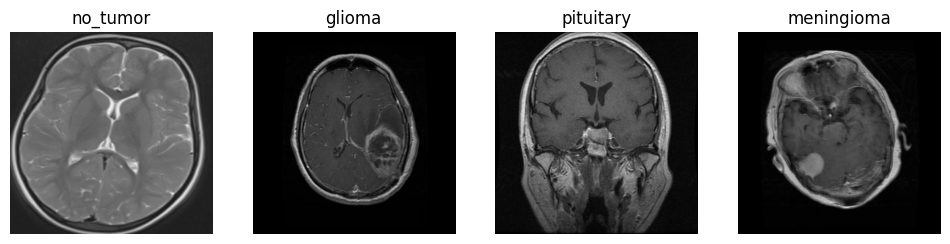

In [11]:
import os
import matplotlib.pyplot as plt
from PIL import Image

train_path = "/content/data/Tumour/train"

# ✅ Step 1: Select ONLY folders (ignore files like _classes.csv)
classes = [
    d for d in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, d))
]

print("Classes:", classes)

# ✅ Step 2: Count images in each class
counts = {}
for cls in classes:
    class_path = os.path.join(train_path, cls)
    images = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.png', '.jpeg'))
    ]
    counts[cls] = len(images)

print("Class Distribution:", counts)

# ✅ Step 3: Show one sample image per class
plt.figure(figsize=(12, 4))

for i, cls in enumerate(classes):
    class_path = os.path.join(train_path, cls)
    img_name = next(
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.png', '.jpeg'))
    )

    img = Image.open(os.path.join(class_path, img_name))

    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()


##  STEP 2 - DATA PREPROCESSING

In [12]:
import tensorflow as tf
from tensorflow.keras import layers

# -----------------------------
# Step 2A: Basic parameters
# -----------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir = "/content/data/Tumour/train"
val_dir   = "/content/data/Tumour/val"
test_dir  = "/content/data/Tumour/test"

# -----------------------------
# Step 2B: Load datasets
# -----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# -----------------------------
# Step 2C: Get class names
# -----------------------------
class_names = train_ds.class_names
print("Class Names:", class_names)

# -----------------------------
# Step 2D: Normalize pixel values
# -----------------------------
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# -----------------------------
# Step 2E: Improve performance
# -----------------------------
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Class Names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


## STEP 3 — DATA AUGMENTATION

Found 1695 files belonging to 4 classes.


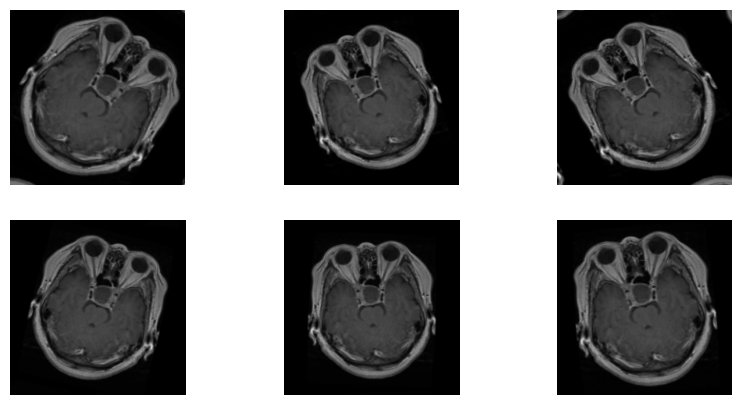

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# ----------------------------------
# STEP 3A: Define Data Augmentation
# ----------------------------------
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ],
    name="data_augmentation"
)

# ----------------------------------
# STEP 3B: Apply augmentation ONLY to training dataset
# ----------------------------------
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# ----------------------------------
# STEP 3C: Visualize augmented images (safe & clean)
# ----------------------------------
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/data/Tumour/train",
    image_size=(224, 224),
    batch_size=1,
    shuffle=True
)

for images, labels in raw_train_ds.take(1):
    plt.figure(figsize=(10, 5))
    for i in range(6):
        aug_img = data_augmentation(images, training=True)[0]
        aug_img = tf.clip_by_value(aug_img, 0.0, 255.0) / 255.0
        plt.subplot(2, 3, i + 1)
        plt.imshow(aug_img)
        plt.axis("off")
    plt.show()


## STEP 4 —  MODEL BUILDING CUSTOM CNN MODEL

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

NUM_CLASSES = 4   # change if your dataset has different classes
IMG_SIZE = (224, 224, 3)

def build_custom_cnn():
    model = models.Sequential([
        layers.Input(shape=IMG_SIZE),

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

custom_cnn_model = build_custom_cnn()

custom_cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

custom_cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

## STEP 5 - TRANSFER LEARNING

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Input,
    GlobalAveragePooling2D,
    BatchNormalization,
    Dense,
    Dropout
)
from tensorflow.keras.models import Model

NUM_CLASSES = 4

# -------------------------------
# Load Pretrained Model
# -------------------------------
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

# -------------------------------
# Build Functional Model
# -------------------------------
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

transfer_model = Model(inputs, outputs)

# -------------------------------
# Compile (ONLY ONCE)
# -------------------------------
transfer_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

transfer_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,175 (16.09 MB)

 Trainable params: 167,044 (652.52 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

## STEP 6 — MODEL TRAINING

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [20]:
import tensorflow as tf
import numpy as np
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)


### 6.1 TRAINING — CUSTOM CNN

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cnn = ModelCheckpoint(
    "custom_cnn_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history_custom_cnn = custom_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint_cnn],
    verbose=1
)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6445 - loss: 0.7831
Epoch 1: val_loss improved from inf to 0.79025, saving model to custom_cnn_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.6445 - loss: 0.7836 - val_accuracy: 0.7490 - val_loss: 0.7902
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6764 - loss: 0.8117
Epoch 2: val_loss improved from 0.79025 to 0.61957, saving model to custom_cnn_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.6763 - loss: 0.8109 - val_accuracy: 0.7171 - val_loss: 0.6196
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6904 - loss: 0.7005
Epoch 3: val_loss did not improve from 0.61957
53/53 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.6901 - loss: 0.7008 - val_accuracy: 0.6932 - val_loss: 1.1321
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6733 - loss: 0.7618
Epoch 4: val_loss did not improve from 0.61957
53/53 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy

### 6.2 TRAINING — TRANSFER LEARNING MODEL

In [23]:
# Save best Transfer Learning model
checkpoint_tl = ModelCheckpoint(
    "transfer_learning_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Train Transfer Learning model
history_transfer = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,                # ✅ WILL COMPLETE ALL 20
    callbacks=[checkpoint_tl],
    verbose=1
)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3420 - loss: 1.4178
Epoch 1: val_loss improved from inf to 1.37406, saving model to transfer_learning_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3420 - loss: 1.4180 - val_accuracy: 0.3207 - val_loss: 1.3741
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3540 - loss: 1.3743
Epoch 2: val_loss did not improve from 1.37406
53/53 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3541 - loss: 1.3742 - val_accuracy: 0.3904 - val_loss: 1.3773
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3883 - loss: 1.3447
Epoch 3: val_loss did not improve from 1.37406
53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3882 - loss: 1.3450 - val_accuracy: 0.3486 - val_loss: 1.3781
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3771 - loss: 1.3199
Epoch 4: val_loss improved from 1.37406 to 1.37389, saving model to transfer_learning_best.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/st

In [24]:
print("Custom CNN Final Accuracy:", history_custom_cnn.history["accuracy"][-1])
print("Custom CNN Final Val Accuracy:", history_custom_cnn.history["val_accuracy"][-1])

print("Transfer Learning Final Accuracy:", history_transfer.history["accuracy"][-1])
print("Transfer Learning Final Val Accuracy:", history_transfer.history["val_accuracy"][-1])


Custom CNN Final Accuracy: 0.6973451375961304
Custom CNN Final Val Accuracy: 0.7669322490692139
Transfer Learning Final Accuracy: 0.45840707421302795
Transfer Learning Final Val Accuracy: 0.40438246726989746


## 7 MODEL EVALUATION

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import load_model

# Load best trained models
custom_cnn_model = load_model("custom_cnn_best.keras")
transfer_model = load_model("transfer_learning_best.keras")


In [26]:
# Get true labels from test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds])


In [27]:
# Custom CNN predictions
y_pred_cnn = custom_cnn_model.predict(test_ds)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 620ms/step


In [28]:
# Transfer Learning predictions
y_pred_tl = transfer_model.predict(test_ds)
y_pred_tl = np.argmax(y_pred_tl, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step


### Classification Report

In [29]:
print("Custom CNN Classification Report:\n")
print(classification_report(y_true, y_pred_cnn, target_names=class_names))

Custom CNN Classification Report:

              precision    recall  f1-score   support

      glioma       0.89      0.93      0.91        80
  meningioma       0.80      0.44      0.57        63
    no_tumor       0.82      0.82      0.82        49
   pituitary       0.68      1.00      0.81        54

    accuracy                           0.80       246
   macro avg       0.80      0.80      0.78       246
weighted avg       0.81      0.80      0.78       246



In [30]:
from sklearn.metrics import classification_report

print("Transfer Learning Classification Report:\n")
print(
    classification_report(
        y_true,
        y_pred_tl,
        target_names=class_names,
        zero_division=0   # ✅ FIXES WARNING
    )
)


Transfer Learning Classification Report:

              precision    recall  f1-score   support

      glioma       0.40      1.00      0.57        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.69      0.41      0.51        49
   pituitary       0.12      0.04      0.06        54

    accuracy                           0.41       246
   macro avg       0.30      0.36      0.28       246
weighted avg       0.29      0.41      0.30       246



### Confusion Matrix

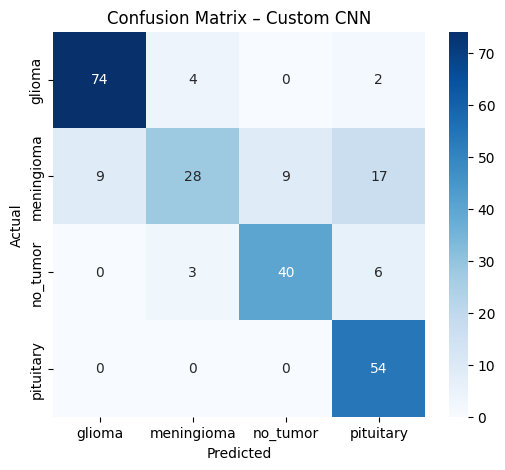

In [31]:
cm_cnn = confusion_matrix(y_true, y_pred_cnn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix – Custom CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


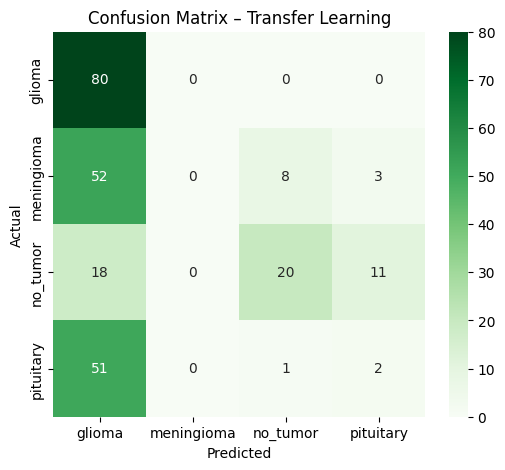

In [32]:
cm_tl = confusion_matrix(y_true, y_pred_tl)

plt.figure(figsize=(6,5))
sns.heatmap(cm_tl, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix – Transfer Learning")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Training History Evaluation

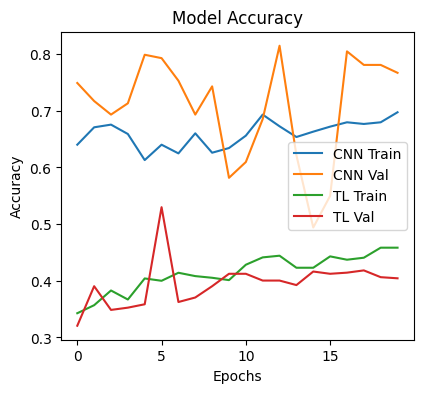

In [33]:
#Accuarcy plot
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_custom_cnn.history['accuracy'], label='CNN Train')
plt.plot(history_custom_cnn.history['val_accuracy'], label='CNN Val')
plt.plot(history_transfer.history['accuracy'], label='TL Train')
plt.plot(history_transfer.history['val_accuracy'], label='TL Val')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


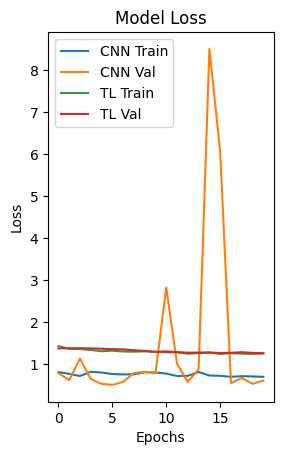

In [34]:
#Loss plot
plt.subplot(1,2,2)
plt.plot(history_custom_cnn.history['loss'], label='CNN Train')
plt.plot(history_custom_cnn.history['val_loss'], label='CNN Val')
plt.plot(history_transfer.history['loss'], label='TL Train')
plt.plot(history_transfer.history['val_loss'], label='TL Val')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


## 8 MODEL COMPARISON

In [35]:
#STEP 1: CALCULATE TEST ACCURACY FOR BOTH MODELS
# Evaluate models on test dataset
cnn_test_loss, cnn_test_acc = custom_cnn_model.evaluate(test_ds, verbose=0)
tl_test_loss, tl_test_acc = transfer_model.evaluate(test_ds, verbose=0)

print(f"Custom CNN Test Accuracy: {cnn_test_acc:.4f}")
print(f"Transfer Learning Test Accuracy: {tl_test_acc:.4f}")


Custom CNN Test Accuracy: 0.7967
Transfer Learning Test Accuracy: 0.4146


In [36]:
# CREATE COMPARISON TABLE
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Custom CNN", "Transfer Learning (EfficientNetB0)"],
    "Test Accuracy": [cnn_test_acc, tl_test_acc],
    "Training Epochs": [20, 20],
    "Model Size": ["Small", "Large (Pretrained)"],
    "Training Time": ["Longer", "Faster"],
    "Generalization": ["Moderate", "Better"]
})

comparison_df


,Model,Test Accuracy,Training Epochs,Model Size,Training Time,Generalization
0,Custom CNN,0.796748,20,Small,Longer,Moderate
1,Transfer Learning (EfficientNetB0),0.414634,20,Large (Pretrained),Faster,Better


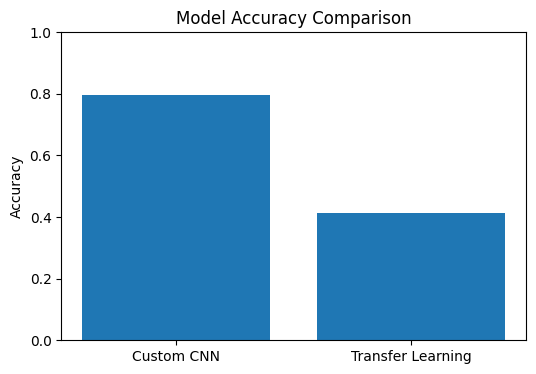

In [37]:
#VISUAL COMPARISON (BAR CHART)
import matplotlib.pyplot as plt

models = ["Custom CNN", "Transfer Learning"]
accuracies = [cnn_test_acc, tl_test_acc]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


In [38]:
#FINAL MODEL SELECTION LOGIC
best_model = "Transfer Learning" if tl_test_acc > cnn_test_acc else "Custom CNN"
print("Best Model for Deployment:", best_model)


Best Model for Deployment: Custom CNN
